## 粘度预测模型（Viscosity Prediction）

本代码实现了一个**基于离子对 SMILES 结构的离子液体粘度预测模型**，整体设计严格参考论文  
**《Predicting Ionic Liquid Materials Properties from Chemical Structure》**，用于复现实验并支持后续迁移学习。

---

### 一、模型整体思路

模型以**阳离子 / 阴离子的分子图结构**为输入，使用 **Message Passing Neural Network (MPNN)** 分别对两种离子进行编码，再将其特征进行融合，最终在**物理约束条件下**预测粘度的对数值。

---

### 二、核心结构

- **输入**
  - 阳离子与阴离子的：
    - 原子类别（atom ids）
    - 键类型（bond ids）
    - 图连接关系（edge indices）
  - 温度 `T`（显式作为模型输入）

- **分子编码（MPNN）**
  - 原子 / 键嵌入（Embedding）
  - 多步消息传递（BondMatrixMessage + GatedUpdate）
  - 全局池化（GlobalSumPool）得到分子指纹

- **离子对融合**
  - 对阳离子与阴离子指纹进行逐元素相加（paper-consistent）
  - 经全连接层生成粘度物理参数

---

### 三、物理约束粘度头

模型并非直接回归粘度，而是学习物理参数：

\[
\log(\eta) = A + \frac{B}{T + C}
\]

其中：
- \(A\)：无约束偏置项  
- \(B\)：通过 `softplus + clip` 约束为正值  
- \(C\)：保证温度平移项为合理正区间  
- 温度 \(T\) 进行物理尺度归一化  

该设计确保预测结果**符合实际物理规律**。

---

### 四、训练与评估

- **数据划分**
  - 默认采用论文中的随机划分（存在 pair-level leakage）
  - 代码中预留了 **严格无泄漏划分（按离子对）** 的可选方案

- **训练设置**
  - Optimizer：Adam（带梯度裁剪）
  - Loss：MSE
  - Early Stopping 防止过拟合
  - 自定义 Callback 控制关键 epoch 输出

- **评估指标**
  - R²（决定系数）
  - MAE（平均绝对误差）

---

### 五、结果可视化与保存

- 绘制训练 / 验证损失曲线
- 生成论文对应的 **Figure 2(a)**：实验值 vs 预测值散点图
- 保存最终模型为 `.keras` 格式，用于后续迁移学习任务

---



===== Viscosity prediction performance =====


I0000 00:00:1765897942.323882  386432 service.cc:145] XLA service 0x7a6bf0014bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765897942.323947  386432 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9


  6/192 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

I0000 00:00:1765897959.461963  386432 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step
Train: R2 = 0.8988, MAE = 0.1628
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 688ms/step
Dev: R2 = 0.8575, MAE = 0.1885
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 705ms/step
Test: R2 = 0.8597, MAE = 0.1856
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


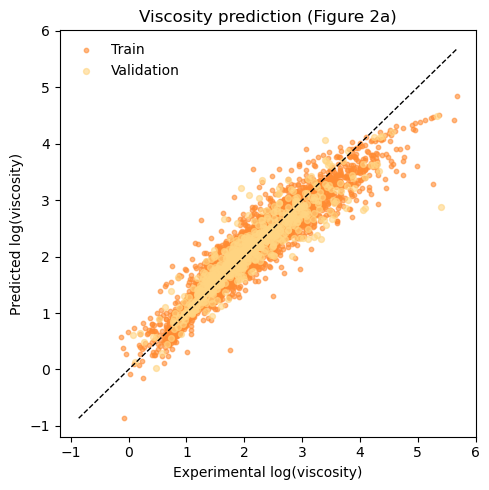

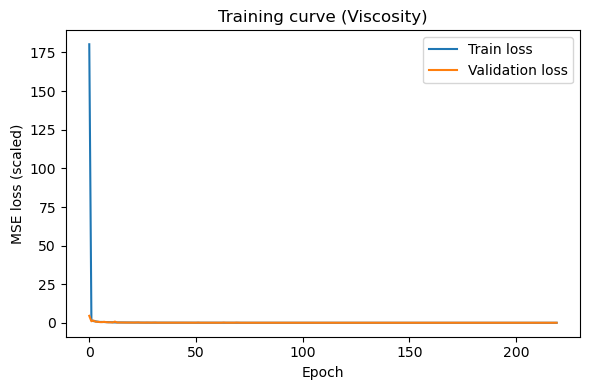

In [1]:
# ============================================================
# Notebook: Viscosity results visualization (Figure 2a)
# 打印 R² / MAE + Figure 2(a) + Loss 曲线
# ============================================================

# ---------- 环境 & 导入 ----------
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split

# 自定义层
from models.layers import (
    BondMatrixMessage, 
    GatedUpdate, 
    GlobalSumPool,
    Reduce, 
    AddTwoTensors, 
    SliceParamA, 
    SliceParamB, 
    SliceParamC,
    ScaleTemperature,
    ComputeLogEta
)

# 复用训练脚本中的工具函数（保持一致性）
from train_viscosity import (
    r2_numpy,
    pad_sequences_1d,
    preprocess_edges_and_bonds,
    plot_loss
)


# ============================================================
# 1. 加载数据
# ============================================================

with open("data/viscosity_id_data.pkl", "rb") as f:
    data = pickle.load(f)

y_all = np.array([d["log_eta"] for d in data], np.float32)

cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]

an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]

T = np.array([d["T"] for d in data], np.float32)[:, None]


# ============================================================
# 2. 数据划分（与 train_viscosity.py 完全一致）
# ============================================================

indices = np.arange(len(data))
idx_train, idx_tmp = train_test_split(indices, test_size=0.20, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

y_train = y_all[idx_train]
y_dev   = y_all[idx_dev]
y_test  = y_all[idx_test]


# ============================================================
# 3. Padding 长度
# ============================================================

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))


# ============================================================
# 4. 构建模型输入
# ============================================================

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
        "temperature": T[idxs],
    }

x_train = build_inputs(idx_train)
x_dev   = build_inputs(idx_dev)
x_test  = build_inputs(idx_test)


# ============================================================
# 5. 加载模型
# ============================================================

model = keras.models.load_model(
    "models/viscosity_final.keras",
    custom_objects={
        "BondMatrixMessage": BondMatrixMessage,
        "GatedUpdate": GatedUpdate,
        "GlobalSumPool": GlobalSumPool,
        "Reduce": Reduce,
        "AddTwoTensors": AddTwoTensors,
        "SliceParamA": SliceParamA,
        "SliceParamB": SliceParamB,
        "SliceParamC": SliceParamC,
        "ScaleTemperature": ScaleTemperature,
        "ComputeLogEta": ComputeLogEta,
    }
)



# ============================================================
# 6. 打印 Train / Dev / Test 的 R² 和 MAE
# ============================================================

print("===== Viscosity prediction performance =====")

for name, x_, y_ in [
    ("Train", x_train, y_train),
    ("Dev",   x_dev,   y_dev),
    ("Test",  x_test,  y_test)
]:
    pred = model.predict(x_).flatten()
    print(
        f"{name}: "
        f"R2 = {r2_numpy(y_, pred):.4f}, "
        f"MAE = {np.mean(np.abs(y_ - pred)):.4f}"
    )


# ============================================================
# 7. 绘制 Figure 2(a)：训练 + 验证
# ============================================================

y_train_pred = model.predict(x_train).flatten()
y_dev_pred   = model.predict(x_dev).flatten()

plt.figure(figsize=(5, 5))

# Train：深橘
plt.scatter(
    y_train,
    y_train_pred,
    s=10,
    alpha=0.6,
    color="#FF8B32",
    label="Train"
)

# Dev：浅橘
plt.scatter(
    y_dev,
    y_dev_pred,
    s=18,
    alpha=0.6,
    color="#FFD582BE",
    label="Validation"
)

low = min(y_train.min(), y_dev.min(), y_train_pred.min(), y_dev_pred.min())
high = max(y_train.max(), y_dev.max(), y_train_pred.max(), y_dev_pred.max())
plt.plot([low, high], [low, high], "k--", linewidth=1)

plt.xlabel("Experimental log(viscosity)")
plt.ylabel("Predicted log(viscosity)")
plt.title("Viscosity prediction (Figure 2a)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


# ============================================================
# 8. 绘制损失曲线（来自 history.pkl）
# ============================================================

with open("results/history_viscosity.pkl", "rb") as f:
    history_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history):
        self.history = history

dummy_history = DummyHistory(history_dict)

plt.figure(figsize=(6, 4))
plt.plot(dummy_history.history["loss"], label="Train loss")
plt.plot(dummy_history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (scaled)")
plt.title("Training curve (Viscosity)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
## 实验结果说明

## 熔点预测模型（Melting Point Prediction）

本 Notebook 实现了一个**基于离子对 SMILES 结构的离子液体熔点预测模型**，严格遵循论文  
**《Predicting Ionic Liquid Materials Properties from Chemical Structure》** 的设计思路，  
用于复现实验并为后续迁移学习任务提供基础模型。

---

### 一、模型整体思路

模型以**阳离子与阴离子的分子图结构**作为输入，使用 **Message Passing Neural Network (MPNN)**  
分别对两种离子进行嵌入编码，融合双离子特征后，通过全连接层回归熔点值（单位：K）。

---

### 二、核心结构

#### 输入数据
- 阳离子 / 阴离子的：
  - 原子类别（`atom_ids`）
  - 键类型（`bond_ids`）
  - 边连接关系（`edge_indices`）
- 所有输入均进行了 **+1 偏移**（预留 `0` 作为 padding）

#### 分子图编码（MPNN）
- 原子与键分别通过 `Embedding` 层映射为向量
- 多轮消息传递：
  - `BondMatrixMessage`：基于可学习张量的邻接消息计算
  - `GatedUpdate`：带门控与 LayerNorm 的原子状态更新
- 图级表示：`GlobalSumPool` 池化非零原子特征

#### 物理融合策略
- 阳离子与阴离子指纹分别线性映射至统一维度
- 采用 **逐元素相加（element-wise sum）**（与原文一致）
- 再经非线性变换生成最终熔点预测

---

### 三、训练策略

#### 数据划分
- 随机划分：80% 训练 / 10% 验证 / 10% 测试（存在 pair-level leakage）
- 保留了按离子种类严格去重划分的扩展接口

#### 标准化处理
- 熔点标签在训练集上进行 Z-score 标准化
- 预测时反标准化以获得真实单位（K）

#### 训练配置
- **优化器**：`Adam(1e-3)` + 梯度裁剪（`clipnorm=1.0`）
- **损失函数**：均方误差（MSE）
- **正则化**：全连接层使用 `L2(1e-5)`
- **早停机制**：验证损失连续 50 轮未改善则终止

#### 日志控制
- 自定义 `SelectiveVerboseCallback`：
  - 仅在关键 epoch 输出日志（如 `1–5, 50, 100, 150, 200` 及最后 5 轮）

---

### 四、评估与可视化

#### 评估指标
- **R²（决定系数）**：衡量模型解释方差的能力
- **MAE（平均绝对误差）**：反映预测偏差的物理尺度

#### 可视化内容
1. **预测 vs 实验值散点图**（对应论文 Figure 2(a) 风格）
   - 训练集（蓝色）与验证集（浅蓝）分布
   - 1:1 参考线辅助评估偏差
2. **训练曲线**
   - 训练/验证 MSE 随 epoch 变化趋势

---

### 五、模型输出与复用

- 模型以 `tf.keras.Model` 实例构建，**未保存为文件**（避免 Keras 3 与 TF/Keras 版本兼容问题）
- 最终可用于：
  - 直接推理新离子对熔点
  - 提取分子指纹用于迁移学习
  - 扩展至其他物性（如粘度、密度）的多任务学习

Atom vocab: 51 Bond vocab: 12


I0000 00:00:1765954235.445945  417870 service.cc:145] XLA service 0x78dc3000cb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765954235.446014  417870 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1765954274.046275  417870 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/1000 - loss: 409.267548 - val_loss: 3.470537
Epoch 2/1000 - loss: 1.839928 - val_loss: 1.904775
Epoch 3/1000 - loss: 1.369513 - val_loss: 0.745120
Epoch 4/1000 - loss: 0.821493 - val_loss: 0.701247
Epoch 5/1000 - loss: 0.866013 - val_loss: 0.493602
Epoch 50/1000 - loss: 0.368916 - val_loss: 0.424007
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step
Train: R2=0.6615, MAE=34.4411
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step
Dev: R2=0.6595, MAE=35.6962
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step
Test: R2=0.6438, MAE=33.8692
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


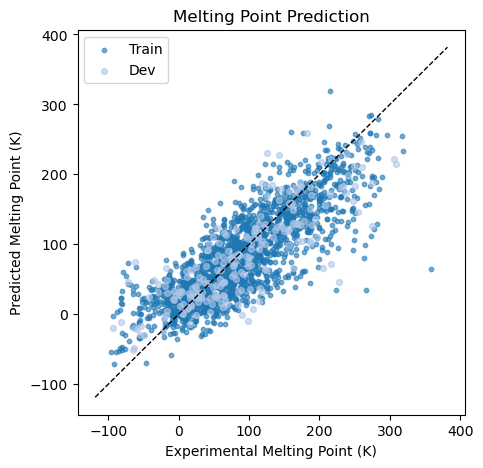

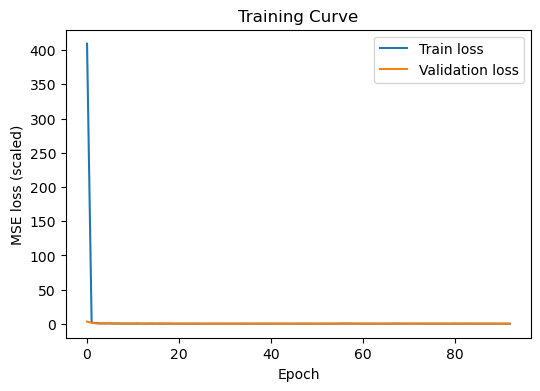

In [2]:
# ============================================================
# Notebook: Melting Point Prediction (MPNN)
# 为避免Keras v3 vs TF/Keras之间版本的冲突，不 load model 而是 build model
# ============================================================

import os
# 抑制 TensorFlow 的 INFO/WARNING 日志
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# 禁用 oneDNN 优化（避免某些环境下的兼容性警告）
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
# 抑制 absl 日志（如 WARNING）
os.environ["ABSL_LOG_LEVEL"] = "2"

import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Embedding, Dense, Add, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# --------------------------
# 1. 加载数据
# --------------------------
with open("data/mp_id_data.pkl", "rb") as f:
    data = pickle.load(f)

# --------------------------
# 2. 工具函数
# --------------------------
EPS = 1e-6

def r2_numpy(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - ss_res / (ss_tot + EPS)

def pad_sequences_1d(seq_list, max_len, pad_val=0):
    return np.array([s + [pad_val]*(max_len - len(s)) for s in seq_list], dtype=np.int32)

def preprocess_edges_and_bonds(edge_list, bond_list, max_edges):
    processed_edges, processed_bonds = [], []
    for edges, bonds in zip(edge_list, bond_list):
        e2, b2 = [], []
        for (src, tgt), bond_id in zip(edges, bonds):
            e2.append([src, tgt])
            b2.append(bond_id)
            e2.append([tgt, src])
            b2.append(bond_id)
        processed_edges.append(e2)
        processed_bonds.append(b2)
    max_len = max_edges*2
    processed_edges = [e + [[0,0]]*(max_len-len(e)) if len(e)<max_len else e[:max_len] for e in processed_edges]
    processed_bonds = [b + [0]*(max_len-len(b)) if len(b)<max_len else b[:max_len] for b in processed_bonds]
    return np.array(processed_edges, dtype=np.int32), np.array(processed_bonds, dtype=np.int32)

class SelectiveVerboseCallback(keras.callbacks.Callback):
    """
    自定义回调：仅在指定 epoch 打印日志
    打印策略：
    - 前 5 轮
    - 特定轮（50,100,150,200…）
    - 最后 5 轮
    """
    def __init__(self, total_epochs):
        super().__init__()
        base = [1, 2, 3, 4, 5, 50, 100, 150, 200]
        last = list(range(total_epochs - 4, total_epochs + 1))
        self.verbose_epochs = set(base + last)
        self.total_epochs = total_epochs

    def on_epoch_end(self, epoch, logs=None):
        e = epoch + 1  # Keras epoch 从 0 开始
        if e in self.verbose_epochs:
            loss = logs.get("loss", 0)
            val_loss = logs.get("val_loss", 0)
            print(f"Epoch {e}/{self.total_epochs} - loss: {loss:.6f} - val_loss: {val_loss:.6f}")

# --------------------------
# 3. 自定义层（MPNN 相关）
# --------------------------
class Reduce(tf.keras.layers.Layer):
    def call(self, inputs):
        messages, tgt_idx, atom_ref = inputs
        batch_size = tf.shape(messages)[0]
        num_edges = tf.shape(messages)[1]
        atom_dim = tf.shape(messages)[2]
        num_atoms = tf.shape(atom_ref)[1]

        batch_idx = tf.range(batch_size, dtype=tf.int32)[:, None]
        batch_idx = tf.tile(batch_idx, [1, num_edges])
        full_idx = tf.stack([batch_idx, tgt_idx], axis=-1)
        full_idx_flat = tf.reshape(full_idx, [-1,2])
        messages_flat = tf.reshape(messages, [-1, atom_dim])
        tgt_flat = tf.reshape(tgt_idx, [-1])
        valid_mask = tf.where(tgt_flat>0, True, False)
        valid_indices = tf.boolean_mask(full_idx_flat, valid_mask)
        valid_updates = tf.boolean_mask(messages_flat, valid_mask)
        aggregated = tf.scatter_nd(valid_indices, valid_updates, shape=(batch_size, num_atoms, atom_dim))
        return aggregated

class BondMatrixMessage(tf.keras.layers.Layer):
    def __init__(self, atom_dim, bond_dim, **kwargs):
        super().__init__(**kwargs)
        self.atom_dim = atom_dim
        self.bond_dim = bond_dim

    def build(self, input_shape):
        self.bond_transform = self.add_weight(
            shape=(self.bond_dim, self.atom_dim, self.atom_dim),
            initializer='glorot_uniform',
            name='bond_transform'
        )
        super().build(input_shape)

    def call(self, inputs):
        atom_state, bond_state, connectivity = inputs
        src_idx = connectivity[:,:,0]
        tgt_idx = connectivity[:,:,1]
        src_atoms = tf.gather(atom_state, src_idx, batch_dims=1)
        bond_mats = tf.tensordot(bond_state, self.bond_transform, axes=[[2],[0]])
        src_exp = tf.expand_dims(src_atoms, -1)
        messages = tf.matmul(bond_mats, src_exp)
        messages = tf.squeeze(messages, axis=-1)
        valid = tf.logical_and(tf.greater(src_idx, 0), tf.greater(tgt_idx,0))
        valid = tf.cast(valid, tf.float32)
        messages = messages * tf.expand_dims(valid,-1)
        return messages

class GatedUpdate(tf.keras.layers.Layer):
    def __init__(self, atom_dim, dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.atom_dim = atom_dim
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.dense_z = Dense(self.atom_dim)
        self.dense_r = Dense(self.atom_dim)
        self.dense_h = Dense(self.atom_dim)
        self.layernorm = LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        super().build(input_shape)

    def call(self, inputs, training=None):
        atom_state, agg = inputs
        concat = tf.concat([atom_state, agg], axis=-1)
        z = tf.nn.sigmoid(self.dense_z(concat))
        r = tf.nn.sigmoid(self.dense_r(concat))
        r_state = r*atom_state
        h_input = tf.concat([r_state, agg], axis=-1)
        h_tilde = tf.nn.tanh(self.dense_h(h_input))
        new_state = (1.0-z)*atom_state + z*h_tilde
        new_state = self.layernorm(new_state)
        new_state = new_state + atom_state
        new_state = self.dropout(new_state, training=training)
        return new_state

class GlobalSumPool(tf.keras.layers.Layer):
    def call(self, inputs):
        atom_features, atom_ids = inputs
        mask = tf.cast(tf.greater(atom_ids,0), tf.float32)
        mask = tf.expand_dims(mask,-1)
        return tf.reduce_sum(atom_features*mask, axis=1)

# --------------------------
# 4. 构建模型函数
# --------------------------
def build_model(atom_vocab_size, bond_vocab_size, atom_dim=32, fp_size=32, mixing_size=20, num_steps=4):
    bond_matrix_dim = atom_dim*atom_dim
    atom_emb = Embedding(atom_vocab_size, atom_dim, mask_zero=False)
    bond_emb = Embedding(bond_vocab_size, bond_matrix_dim, mask_zero=False)

    def encode(atom_ids, bond_ids, conn, prefix):
        h = atom_emb(atom_ids)
        b = bond_emb(bond_ids)
        for i in range(num_steps):
            m = BondMatrixMessage(atom_dim, bond_matrix_dim, name=f"{prefix}_bmm_{i}")([h,b,conn])
            agg = Reduce(name=f"{prefix}_reduce_{i}")([m, conn[:,:,1], h])
            h = GatedUpdate(atom_dim)([h,agg])
        fp = GlobalSumPool()([h, atom_ids])
        fp = Dense(fp_size, activation="relu", kernel_regularizer=l2(1e-5))(fp)
        return fp

    # 输入
    cat_atom = Input(shape=(None,), dtype=tf.int32, name="cat_atom")
    cat_bond = Input(shape=(None,), dtype=tf.int32, name="cat_bond")
    cat_conn = Input(shape=(None,2), dtype=tf.int32, name="cat_connectivity")
    an_atom = Input(shape=(None,), dtype=tf.int32, name="an_atom")
    an_bond = Input(shape=(None,), dtype=tf.int32, name="an_bond")
    an_conn = Input(shape=(None,2), dtype=tf.int32, name="an_connectivity")

    fp_cat = encode(cat_atom, cat_bond, cat_conn, "cat")
    fp_an = encode(an_atom, an_bond, an_conn, "an")

    mixed = Add()([
        Dense(mixing_size, activation="relu")(fp_cat),
        Dense(mixing_size, activation="relu")(fp_an)
    ])

    x = Dense(fp_size, activation="relu", kernel_regularizer=l2(1e-5))(mixed)
    out = Dense(1)(x)

    model = Model(inputs=[cat_atom,cat_bond,cat_conn,an_atom,an_bond,an_conn], outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3, clipnorm=1.0), loss="mse")
    return model

# --------------------------
# 5. 安全计算 vocab_size
# --------------------------
def safe_max(lst):
    return max(lst) if lst else 0

atom_vocab_size = max(
    safe_max([safe_max(d["cation"]["atom_ids"]) for d in data]),
    safe_max([safe_max(d["anion"]["atom_ids"]) for d in data])
) + 2

bond_vocab_size = max(
    safe_max([safe_max(d["cation"]["bond_ids"]) for d in data]),
    safe_max([safe_max(d["anion"]["bond_ids"]) for d in data])
) + 2

print("Atom vocab:", atom_vocab_size, "Bond vocab:", bond_vocab_size)

# --------------------------
# 6. 特征 & 标签处理
# --------------------------
cat_atoms = [[a+1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b+1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]
an_atoms = [[a+1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds = [[b+1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges = [d["anion"]["edge_indices"] for d in data]
Y_all = np.array([d["mp"] for d in data], np.float32)

indices = np.arange(len(data))
idx_train, idx_tmp = train_test_split(indices, test_size=0.2, random_state=42)
idx_dev, idx_test = train_test_split(idx_tmp, test_size=0.5, random_state=42)

Y_mean = Y_all[idx_train].mean()
Y_std = Y_all[idx_train].std() or 1.0
Y_scaled = (Y_all - Y_mean)/Y_std

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds([cat_edges[i] for i in idxs], [cat_bonds[i] for i in idxs], max_edges)
    ae, ab = preprocess_edges_and_bonds([an_edges[i] for i in idxs], [an_bonds[i] for i in idxs], max_edges)
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
    }

x_train = build_inputs(idx_train)
x_dev = build_inputs(idx_dev)
x_test = build_inputs(idx_test)

# --------------------------
# 7. 构建 & 训练模型
# --------------------------
EPOCHS = 1000

model = build_model(atom_vocab_size, bond_vocab_size)

history = model.fit(
    x_train, Y_scaled[idx_train],
    validation_data=(x_dev, Y_scaled[idx_dev]),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=50, restore_best_weights=True),
        SelectiveVerboseCallback(EPOCHS)
    ],
    verbose=0
)

# --------------------------
# 8. 预测 & 评估
# --------------------------
def predict_and_unscale(x_):
    return model.predict(x_).flatten()*Y_std + Y_mean

for name, x_, y_true in [("Train", x_train, Y_all[idx_train]),
                          ("Dev", x_dev, Y_all[idx_dev]),
                          ("Test", x_test, Y_all[idx_test])]:
    pred = predict_and_unscale(x_)
    print(f"{name}: R2={r2_numpy(y_true,pred):.4f}, MAE={np.mean(np.abs(y_true-pred)):.4f}")

# --------------------------
# 9. 绘图
# --------------------------
y_train_pred = predict_and_unscale(x_train)
y_dev_pred = predict_and_unscale(x_dev)

plt.figure(figsize=(5,5))
plt.scatter(Y_all[idx_train], y_train_pred, s=10, alpha=0.6, color="#1f77b4", label="Train")
plt.scatter(Y_all[idx_dev], y_dev_pred, s=18, alpha=0.6, color="#aec7e8", label="Dev")
low = min(Y_all[idx_train].min(), Y_all[idx_dev].min(), y_train_pred.min(), y_dev_pred.min())
high = max(Y_all[idx_train].max(), Y_all[idx_dev].max(), y_train_pred.max(), y_dev_pred.max())
padding = (high-low)*0.05
plt.plot([low-padding, high+padding], [low-padding, high+padding], "k--", linewidth=1)
plt.xlabel("Experimental Melting Point (K)")
plt.ylabel("Predicted Melting Point (K)")
plt.title("Melting Point Prediction")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (scaled)")
plt.title("Training Curve")
plt.legend()
plt.show()


In [ ]:
# ============================================================
# In Jupyter Notebook: 熔点预测（迁移学习）—— 单 cell 版本
# 要求：notebook 位于项目根目录，且 train_viscosity.py 可导入
# ============================================================

import os
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras
from pathlib import Path

# ========== 配置参数（替代 absl.flags）==========
VISCOSITY_MODEL_PATH = "models/viscosity_final.keras"  # 可按需修改
LEARNING_RATE = 1e-3
TOTAL_EPOCHS = 1000

# ========== 导入自定义层 ==========
from models.layers import (
    BondMatrixMessage, GatedUpdate, GlobalSumPool, Reduce,
    AddTwoTensors, SliceParamA, SliceParamB, SliceParamC,
    ScaleTemperature, ComputeLogEta
)

# ========== 复用粘度训练脚本中的工具 ==========
from train_viscosity import (
    r2_numpy,
    pad_sequences_1d,
    preprocess_edges_and_bonds,
    SelectiveVerboseCallback,
    plot_loss
)

EPS = 1e-6
BASE_DIR = Path.cwd()
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

# ========== 模型构建 ==========
def build_transfer_model(viscosity_model_path, freeze_base=True, dropout_rate=0.2):
    temp_model = keras.models.load_model(
        viscosity_model_path,
        custom_objects={
            "BondMatrixMessage": BondMatrixMessage,
            "GatedUpdate": GatedUpdate,
            "GlobalSumPool": GlobalSumPool,
            "Reduce": Reduce,
            "AddTwoTensors": AddTwoTensors,
            "SliceParamA": SliceParamA,
            "SliceParamB": SliceParamB,
            "SliceParamC": SliceParamC,
            "ScaleTemperature": ScaleTemperature,
            "ComputeLogEta": ComputeLogEta
        }
    )
    mixed_fp = temp_model.get_layer("mix_cat_an").output
    transfer_inputs = temp_model.inputs[:6]
    feature_extractor = keras.Model(inputs=transfer_inputs, outputs=mixed_fp, name="feature_extractor")
    if freeze_base:
        feature_extractor.trainable = False
    x = feature_extractor.output
    x = keras.layers.Dense(64, activation="relu", name="mp_dense_1")(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(32, activation="relu", name="mp_dense_2")(x)
    mp_output = keras.layers.Dense(1, name="melting_point")(x)
    final_model = keras.Model(inputs=feature_extractor.inputs, outputs=mp_output)
    return final_model

# ========== 主流程 ==========
# 加载数据
with open("data/melting_point_id_data.pkl", "rb") as f:
    data = pickle.load(f)
with open("data/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]
an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]
y = np.array([d["mp"] for d in data], dtype=np.float32)

# 划分数据集
from sklearn.model_selection import train_test_split
indices = np.arange(len(data))
idx_train, idx_tmp = train_test_split(indices, test_size=0.20, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)
print(f"数据划分完成: Train={len(idx_train)}, Dev={len(idx_dev)}, Test={len(idx_test)}")

# 构建输入
max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
    }

x_train = build_inputs(idx_train)
x_dev   = build_inputs(idx_dev)
x_test  = build_inputs(idx_test)
y_train, y_dev, y_test = y[idx_train], y[idx_dev], y[idx_test]

# 标签缩放（[-1, 1]）
y_min, y_max = y_train.min(), y_train.max()
def scale(y): return 2 * (y - y_min) / (y_max - y_min + EPS) - 1
def inverse_scale(y): return (y + 1) * 0.5 * (y_max - y_min) + y_min
y_train_s = scale(y_train)
y_dev_s   = scale(y_dev)

# 构建并编译模型
model = build_transfer_model(VISCOSITY_MODEL_PATH)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

# 训练
history = model.fit(
    x_train, y_train_s,
    validation_data=(x_dev, y_dev_s),
    epochs=TOTAL_EPOCHS,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True),
        SelectiveVerboseCallback(total_epochs=TOTAL_EPOCHS)
    ],
    verbose=0
)

# 保存模型和历史
model.save(MODELS_DIR / "melting_point_transfer_final.keras", save_format="keras_v3")
os.makedirs("results", exist_ok=True)
with open("results/history_melting_point_transfer.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("Saved training history to results/history_melting_point_transfer.pkl")
plot_loss(history, "results/loss_melting_point_transfer.png")

# 评估
for name, x_, y_ in [("Train", x_train, y_train), ("Dev", x_dev, y_dev), ("Test", x_test, y_test)]:
    pred = inverse_scale(model.predict(x_, verbose=0).flatten())
    print(f"{name}: R2={r2_numpy(y_, pred):.4f}, MAE={np.mean(np.abs(y_ - pred)):.4f}")

# 绘图：Figure 2(c)
y_train_pred = inverse_scale(model.predict(x_train, verbose=0).flatten())
y_dev_pred   = inverse_scale(model.predict(x_dev, verbose=0).flatten())
plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_train_pred, s=10, alpha=0.6, color="#2E7D32", label="Train")
plt.scatter(y_dev, y_dev_pred, s=18, alpha=0.6, color="#A5D6A7", label="Validation")
low = min(y_train.min(), y_dev.min(), y_train_pred.min(), y_dev_pred.min())
high = max(y_train.max(), y_dev.max(), y_train_pred.max(), y_dev_pred.max())
plt.plot([low, high], [low, high], "k--", linewidth=1)
plt.xlabel("Experimental melting point (K)")
plt.ylabel("Predicted melting point (K)")
plt.title("Melting point prediction (transfer learning)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("results/figure2_c_melting_point_transfer.png", dpi=300)
plt.show()

数据划分完成: Train=1769, Dev=221, Test=222
